- select the best params

we will select the model using 50k strings of data, then search the best params with more

In [2]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
import gc
import joblib

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from google.colab.patches import cv2_imshow

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### loading data

In [3]:
full_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/handwritten_symb/data.csv')
full_data.shape

(333895, 786)

In [4]:
full_data.to_csv('./data.csv', index=False)

In [5]:
del full_data
gc.collect()

0

In [6]:
data = pd.read_csv('/content/data.csv', nrows=50000)
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,2,255,255,255,255,237,91,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,3,0,0,0,0,0,0,0,150,187,...,0,0,0,0,0,0,0,0,0,1
4,4,0,0,0,0,0,0,0,0,123,...,0,0,0,0,0,0,0,0,0,9


In [7]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,255,255,255,255,237,91,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,150,187,14,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,123,255,...,0,0,0,0,0,0,0,0,0,9


### train test split

In [9]:
x = data.drop(columns=['784'])
y = data['784']
x.shape, y.shape

((50000, 784), (50000,))

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=21)

### Random Forest Classifier

In [57]:
params = {
    'n_estimators': 400,
    'random_state': 21,
    'max_depth': 10,
    'min_samples_leaf': 1,
    'min_samples_split': 3,
    'n_jobs': 3
}


In [58]:
model = RandomForestClassifier(**params)

In [59]:
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=400,
                       n_jobs=3, random_state=21)

In [60]:
y_pred = model.predict(x_test)

In [61]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       601
           1       0.85      0.64      0.73       607
           2       0.86      0.78      0.82       601
           3       0.88      0.74      0.80       675
           4       0.80      0.90      0.85       673
           5       0.81      0.89      0.85       627
           6       0.94      0.93      0.94       622
           7       0.82      0.74      0.78       621
           8       0.91      0.89      0.90       607
           9       0.75      0.79      0.77       647
          10       0.90      0.95      0.93       665
          11       0.75      0.76      0.75       640
          12       0.94      0.87      0.90       584
          13       0.78      0.97      0.87       690
          14       0.91      0.91      0.91       596
          15       0.81      0.82      0.82       544

    accuracy                           0.85     10000
   macro avg       0.85   

In [ ]:
# joblib.dump(model, './random_forest.pkl')

['./random_forest.pkl']

In [90]:
def letters_extract(image_file: str, out_size=28):
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1)

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    output = img.copy()

    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        # print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        # hierarchy[i][0]: the index of the next contour of the same level
        # hierarchy[i][1]: the index of the previous contour of the same level
        # hierarchy[i][2]: the index of the first child
        # hierarchy[i][3]: the index of the parent
        if hierarchy[0][idx][3] == 0:
            cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)
            letter_crop = thresh[y:y + h, x:x + w]
            # print(letter_crop.shape)

            # Resize letter canvas to square
            size_max = max(w, h)
            letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
            if w > h:
                # Enlarge image top-bottom
                # ------
                # ======
                # ------
                y_pos = size_max//2 - h//2
                letter_square[y_pos:y_pos + h, 0:w] = letter_crop
            elif w < h:
                # Enlarge image left-right
                # --||--
                x_pos = size_max//2 - w//2
                letter_square[0:h, x_pos:x_pos + w] = letter_crop
            else:
                letter_square = letter_crop

            # Resize letter to 28x28 and add letter and its X-coordinate
            letter_square[letter_square>0] = 255
            resize = cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)
            cv2.imwrite('./test.png', resize)
            letters.append((x, w, resize))

    # Sort array in place by X-coordinate
    letters.sort(key=lambda x: x[0], reverse=False)

    return letters, output

In [94]:
letters, output = letters_extract('/content/equasion.jpg')

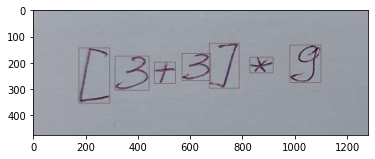

In [95]:
plt.imshow(output)

In [96]:
result = []
figure = []
for i in range(len(letters)):
  figure = np.reshape(letters[i][2], (1, 784))
  cv2_imshow(letters[i][2])
  figure = ~figure
  re = model.predict(figure)
  print(re)
  result.append(re)

result

[11]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[5]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[11]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[5]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[11]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[11]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[11]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[11]


[array([11]),
 array([5]),
 array([11]),
 array([5]),
 array([11]),
 array([11]),
 array([11]),
 array([11])]